(In order to load the stylesheet of this notebook, execute the last code cell in this notebook)

# Yelp Reviews and Clustering

In this assignment, we will be working with the [Yelp dataset](http://cs-people.bu.edu/kzhao/teaching/yelp_dataset_challenge_academic_dataset.tar). You can find the format of the dataset [here](https://www.yelp.com/dataset_challenge).

First, we will look at Review Objects and perform some [sentiment analysis](http://sentiment.christopherpotts.net/) on the review text.

You will need to preprocess the text using a stemming algorithm. The Porter stemming algorithm is a well-known one. Then, use a lexicon to assign a score to a review based on the positive/negative words you find in the text. You can find various lexicons [here](http://sentiment.christopherpotts.net/lexicons.html).

After you have assigned scores to the reviews based on the text analysis, compare your scores with the stars associated with the reviews. **(20 pts)**

open yelp_academic_dataset_review.json
DEBUG: 	done

pred: Counter({4.0: 971218, 5: 785794, 3.0: 359385, 2.0: 104903, 1: 3913})
data: Counter({5: 900940, 4: 591618, 3: 282115, 1: 260492, 2: 190048})
percentages: Counter({5: 1196484, 4: 608720, 3: 307802, 2: 95438, 1: 16769})


/home/sahil/anaconda2/lib/python2.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


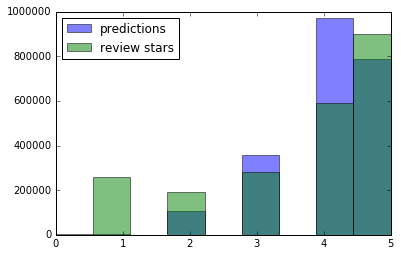

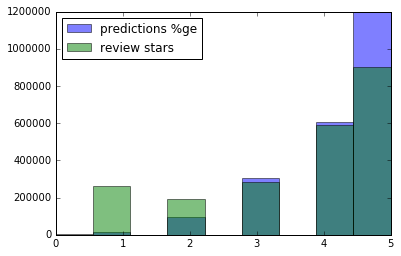

2088.493011 sec


In [5]:
import json
import time,sys, math
import collections
import re
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import nltk
from nltk.stem import PorterStemmer as ps
#from nltk import sentiment
from nltk.sentiment.vader import SentimentIntensityAnalyzer


-%matplotlib inline


class Solution:
    def __init__(self):
        self.review_dump = collections.defaultdict(list) #key=userid, value=[reviewid,text,stars]
        self.review_stem = []
        self.review_score = collections.defaultdict(list)
        self.posDict = collections.defaultdict(str)
        self.negDict = collections.defaultdict(str)
        self.predictions = []
        self.stars = []
        self.predictions_perc = []
        self.correction = 0.2
    def parseReviews(self,path):
        reviewfile = open(path,"r")           
        print "open",path
        for line in reviewfile:
            #print "DEBUG", line
            temp_decode = json.loads(line)            
            #self.review_score = 0
            #score = self.getScore(temp_decode["text"].split())
            score, perc = self.getScore(re.findall(r"[\w']+|[.,!?;]",temp_decode["text"],re.UNICODE))
            #print score
            #if score < 5:
            #print len(temp_decode['text']), math.ceil(score), temp_decode['stars']
            #if abs(int(5*score) - temp_decode['stars']) > 2:
                #print 'debug: outlier review:', temp_decode['text'], int(5*score), temp_decode['stars']
            #self.review_score[temp_decode['review_id']] = [int(5*score), temp_decode['stars']]            
            
            self.predictions.append(max(1,min(5,math.ceil(score+self.correction))))
            self.stars.append(temp_decode['stars'])
            self.predictions_perc.append(perc)
            
        print "DEBUG: \tdone\n"#, self.review_dump
        reviewfile.close()
        print "pred:", Counter(self.predictions)
        print "data:",Counter(self.stars)
        print "percentages:", Counter(self.predictions_perc)
        #print self.predictions, self.stars
    def getScore(self, text):
        #print "DEBUG: time to stem"
        #print text
        stemmer = ps()
        retscore = 0.0
        self.review_stem = [stemmer.stem(w.lower()) for w in text]
        #print "DEBUG", self.review_stem
        #get lexicon score for review_stem[] and return positive/negative
        pos = 1
        neg = 1
        for w in self.review_stem:    
            if w in "!.,;'": continue
            if self.posDict[w]:
                #retscore += 1
                pos += 1
            elif self.negDict[w]:
                #retscore -= 1
                neg += 1
        stars = (6*float(pos)/float(pos+neg))
        #print int(stars), stars, int(stars)*1.0 - stars
        if abs(int(stars)*1.0 - stars) > self.correction:
            stars = math.ceil(stars)
        else:
            stars = int(stars)
        perc =  int(max(1, min(5,stars)))
        
        #retscore = max(0, min(5,(pos-neg)/(pos+neg)))
        #retscore =  1.0*(pos-neg)/len(text)
            #print "DEBUG", posline,
        #print self.review_score, self.review_stem
        
        retscore = float(pos-neg)/float(pos+neg)
        if not retscore:
            return 2.5, perc #midpoint
        
        return 2.5+2.5*retscore, perc #also consider review length for score
        
            
        
if __name__ == "__main__":
    starttime = time.time()
    s = Solution()
    #construct a positive word directory of 2006 words - if a word not found, consider negative
    
    posfile = open("positive-words.txt","r")
    for posline in posfile:
        if posline[0] == ';' or posline[0]=='\n': #header ignore and empty lines
            continue
        s.posDict[posline.split("\n")[0].lower()] = 1
            
    negfile = open("negative-words.txt","r")
    for negline in negfile:
        if negline[0] == ';' or negline[0]=='\n': #header ignore and empty lines
            continue
        s.negDict[negline.split("\n")[0].lower()] = 1    
    s.parseReviews("yelp_academic_dataset_review.json")
    bins = np.linspace(0,5,10)
    plt.hist(s.predictions, bins, alpha = 0.5, label='predictions')
    plt.hist(s.stars, bins, alpha = 0.5, label='review stars')
    plt.legend(loc='upper left')
    plt.show()
    
    plt.hist(s.predictions_perc, bins, alpha = 0.5, label='predictions %ge')
    plt.hist(s.stars, bins, alpha = 0.5, label='review stars')
    plt.legend(loc='upper left')
    plt.show()
    
    print time.time()-starttime, "sec"

Visualization and short (detailed) analysis. **(10 pts)**

In [ ]:
Bing Liu's Opinion Lexicon http://sentiment.christopherpotts.net/lexicons.html
Positive words: 2006
Negative words: 4783
    
approach one: 
        return int(max(0, min(5,6*float(pos)/float(pos+neg))))

approach two: 
        retscore = float(pos-neg)/float(pos+neg)
        if not retscore:
            return 2.5 #midpoint
        
        return 2.5+2.5*retscore

-----------------

Now, let's look at Business Objects. Try to find culinary districts in Las Vegas. These are characterized by closeness and similarity of restaurants. Use the "longitude" and "latitude" to cluster closeness. Use "categories" and "attributes" to cluster for similarity.

Find clusters using the 3 different techniques we discussed in class: k-means++, hierarchical, and GMM. Explain your data representation and how you determined certain parameters (for example, the number of clusters in k-means++). **(30 pts)**

Things you may want to consider:
1. The spatial coordinates and restaurant categories/attributes have different units of scale. Your results could be arbitrarily skewed if you don't incorporate some scaling.
2. Some restaurant types are inherently more common than others. For example, there are probably lots of "pizza" restaurants. You may want to normalize your vectors so that you don't end up with only clusters of "pizza" restaurants.

Counter({9: 532, 1: 530, 3: 310, 5: 214, 15: 1})
plotting all 1587 1587 1587
[[ 1.4122109   0.11231171 -1.61214641  1.11342084]
 [ 1.4122109  -1.07199851  0.01025627  1.18046517]
 [-0.70810953 -0.4798434  -0.08365432 -0.08104799]
 ..., 
 [ 1.4122109   1.29662193 -1.24821333 -1.23935986]
 [-0.70810953  1.29662193  1.84386739  0.23718322]
 [-0.70810953 -0.4798434  -0.30326603 -0.06480863]]


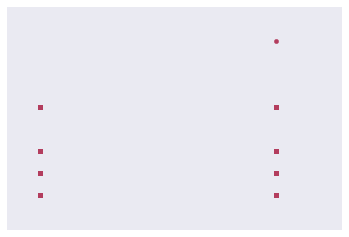

In [62]:
import json
from pprint import pprint
import numpy as np
import re
import collections
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from collections import Counter
from sklearn.manifold import MDS
import sklearn.metrics as metrics
from scipy.spatial.distance import pdist
import scipy.cluster.hierarchy as hr
from sklearn import preprocessing
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
import random
from sklearn import mixture

from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.cluster import KMeans
import seaborn as sns
from scipy.cluster.vq import kmeans,vq
from matplotlib.mlab import PCA
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import mixture

%matplotlib inline
def randomColors(k):
    ret = 0.0
    if k==1:
        ret = (1,random.uniform(0.2,0.5), 0.0)
    elif k == 3:
        ret = (random.uniform(0.2,0.3),1, 0.0)
    elif k == 5:
        ret = (random.uniform(0.3,0.5), 0.75, 1)
    else:
        ret = (random.uniform(0.3,0.5),0.2, random.uniform(0.2,0.5))
    #print "colors", ret
    return ret
def getLabels(grlist):
    ret = []
    for groups in grlist:
        if groups == '1':
            ret.append("American/pubs")
        if groups == '3':
            ret.append("Chinese/kid friendly")
        if groups == '5':
            ret.append("Italian/outdoors")
        if groups == '9':
            ret.append("Mexican/pubs")
    
    return ret
def kmeansPlotVegas():
    #print vegasdict
    #vegasclusters = [[] for i in range(len(vegasvq))]
    vegasclusters = collections.defaultdict(list)
    legends = collections.defaultdict(list)
    #im = plt.imread('vegas.png')
    #implot = plt.imshow(im)
    plt.figure(1)
    categories = Counter(vegasdict['categ'])
    print categories
    for c,v in categories.items():
        latlist = []
        longlist = []
        
        for i in xrange(0, len(vegasdict['categ'])):
            if vegasdict['categ'][i] == c:            
                latlist.append(vegasdict['lat'][i])
                longlist.append(vegasdict['long'][i])
        if len(latlist)<17 or len(longlist)<17:
            continue
        print "plotting", c
        vegasdf = pd.DataFrame({'lat':longlist, 'long':latlist})
        #print vegasdf
        vegasmatrix = vegasdf.as_matrix()
    #print vegasmatrix
        kmeans=KMeans(init='k-means++',n_clusters=17,n_init=10)
        kmeans.fit_predict(vegasmatrix)
        centroids = kmeans.cluster_centers_
        vegasvq = vq(vegasmatrix, centroids)[0]
        vegasclusters[c] = [[] for i in range(len(vegasvq))]
        
        for item, clustN in zip(vegasmatrix, vegasvq):
            vegasclusters[c][clustN].append(item)
        for cl in vegasclusters[c]:
            legends[c]=plt.scatter([item[0] for item in cl],[item[1] for item in cl],marker='o', color=randomColors(c), alpha=0.5)
            
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plots = map(lambda k:k[1], legends.items())
    labels = getLabels(map(lambda k:str(k), legends.keys()))
    print labels
    plt.legend(plots, labels, loc='upper left')
    plt.title("KMeans++")
    plt.show()


def hierarchicalPlot():
    plt.figure(2)
    
    categories = Counter(vegasdict['categ'])
    print categories
    latlist = vegasdict['lat']
    longlist = vegasdict['long']
    categlist = vegasdict['categ']
    attrlist = vegasdict['attr']
    """
    for c,v in categories.items():
        
        
        for i in xrange(0, len(vegasdict['categ'])):
            if vegasdict['categ'][i] == c:            
                latlist.append(vegasdict['lat'][i])
                longlist.append(vegasdict['long'][i])
                categlist.append(vegasdict['categ'][i])
                attrlist.append(vegasdict['attr'][i])
        if len(latlist)<17 or len(longlist)<17:
            continue
    """
    print "plotting all", len(longlist), len(latlist), len(categlist)
    vegasdf = pd.DataFrame({'lat':longlist, 'long':latlist, 'cat':categlist, 'attr':attrlist})
    #print vegasdf
    distancematrix=pdist(vegasdf,'euclidean')
    #print distancematrix
    Z = hr.linkage(vegasdf, method='complete', metric='euclidean')

    ck = hr.fcluster(hr.linkage(distancematrix, method='complete'), 1.5,'distance')
    fig=plt.figure(figsize=(10,10))
    T = hr.dendrogram(Z,color_threshold=1, leaf_font_size=4)
    """
    distancematrix=pdist(df6,'euclidean')
    Z = hr.linkage(df6, method='complete', metric='euclidean')


    ck = hr.fcluster(hr.linkage(distancematrix, method='complete'), 1.5,'distance')
    print ck

    fig=plt.figure(figsize=(10,10))
    T = hr.dendrogram(Z,color_threshold=1, leaf_font_size=4)
    fig.show()

    """
    
    plt.title("Hierarchical")
    plt.show()

def GMMPlot():
    plt.figure(3)
    
    categories = Counter(vegasdict['categ'])
    print categories
    latlist = vegasdict['lat']
    longlist = vegasdict['long']
    categlist = vegasdict['categ']
    attrlist = vegasdict['attr']

    print "plotting all", len(longlist), len(latlist), len(categlist)
    vegasdf = pd.DataFrame({'lat':longlist, 'long':latlist, 'cat':categlist, 'attr':attrlist})
    #print vegasdf
    X = StandardScaler().fit_transform(vegasdf)
    
    clf = mixture.GMM(n_components=17, covariance_type='full')
    clf.fit(X)
    
    print X
    classift = clf.predict(X)
    plt.scatter(X[:,0],X[:,1], color = (random.uniform(0.5,1.0), random.uniform(0.2,0.7), random.uniform(0.2,0.6)))
    plt.xticks(())
    plt.yticks(())
    
    plt.show()
    
def parseVegas(path):
    vegasfile = open(path, "r")
    for vegasline in vegasfile:
        vegasdecode = json.loads(vegasline)
        if vegasdecode['city']== "Las Vegas":
            #print vegasdecode['business_id'], vegasdecode['latitude'], vegasdecode['longitude']
            #print "####", filter(lambda k:k[1]==True, vegasdecode['attributes'].items()), "###"
            attrset = filter(lambda k:k[1]==True, vegasdecode['attributes'].items())
            attrnames = map(lambda k:k[0], attrset)
            """
            attrset = vegasdecode['attributes']
            attrnames = []
            if attrset['Ambience']['romantic'] == True:
                attrnames += 'romantic'
            if attrset['Ambience']['upscale'] == True:
                attrnames += 'upscale'
            if attrset['Ambience']['casual'] == True:
                attrnames += 'casual'
            """
            attflag, categflag = False, False
            categset = vegasdecode['categories']
            #print categset
            tempattr= 1
            for attr in attrnames:
                #print attr,"!!!"                
                if attr.lower() in attrDict:
                    #print vegasdecode['attributes']
                    attflag = True
                    tempattr |= 1<< attrDict[attr.lower()]
            if attflag:
                tempcateg = 1
                for categ in categset:
                    #print categ, categ.lower() in categoryDict
                    if categ.lower().split(" ")[0] in categoryDict:
                        #print "IN", categ
                        categflag = True
                        tempcateg |= 1 << categoryDict[categ.lower().split(" ")[0]]
                if categflag:
                    vegasdict['attr'].append(tempattr)
                    vegasdict['categ'].append(tempcateg) 
                    vegasdict['lat'].append(vegasdecode['latitude'])
                    vegasdict['long'].append(vegasdecode['longitude'])
    #print vegasdict['lat'][0]
    #kmeansPlotVegas()
    #hierarchicalPlot()
    GMMPlot()
    
vegasdict = collections.defaultdict(list)               
attrDict = {"good for kids":0, "pubs":1, "outdoor seating":2}                
categoryDict = {'american':0, 'chinese':1, 'italian':2, 'mexican':3}
parseVegas("yelp_academic_dataset_business.json")







Visualize your clusters using each technique. Label your clusters. **(10 pts)**

Now let's detect outliers. These are the ones who are the farthest from the centroids of their clusters. Track them down and describe any interesting observations that you can make. **(10 pts)**

Give a short (detailed) analysis comparing the 3 techniques. **(10 pts)**

-----------------

In [ ]:
# Code for setting the style of the notebook
from IPython.core.display import HTML
def css_styling():
    styles = open("../theme/custom.css", "r").read()
    return HTML(styles)
css_styling()